## 提高循环神经网络的性能和泛华能力的技巧
- 循环dropout
- 堆叠循环层
- 双向循环层

In [1]:
#导入数据
import os

data_dir = 'D:\\Jupyter\\Keras\\jena_climate_2009_2016.csv\\'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
#使用Numpy解析数据
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

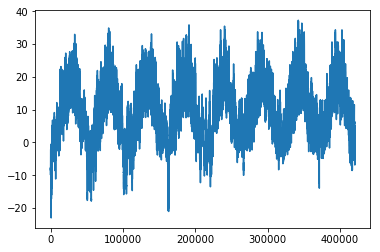

In [3]:
#绘制温度时间序列
from matplotlib import pyplot as plt

temp = float_data[:, 1] #温度（摄氏度）
plt.plot(range(len(temp)), temp)
plt.show()

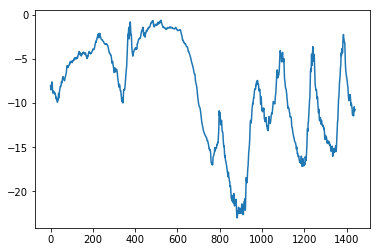

In [4]:
#每10分钟记录一个数据，所以一天有144个数据点，绘制10天（是冬天）
plt.plot(range(1440), temp[:1440])
plt.show()

### 以月作为时间序列比较准确，因为有可靠的年度周期性，那以天为观测尺度，这个时间序列是可以预测的吗？

### 准备数据

In [5]:
#数据标准化
mean = float_data[:200000].mean(axis=0)#每列数据标准化
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
#生成时间序列样本机器目标生成器
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay -1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))#从min_index + lookback到i + batch_size（如果到max则max）
            i += len(rows)
#rows代表在数据数目中的位置  
        samples = np.zeros((len(rows),#batch_size
                           lookback // step,#讲loockback个时间部的数据化为几个步
                           data.shape[-1]))#每条时间序列有data.shape【-1】个属性
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):#循环batch_size次
            indices = range(rows[j] - lookback, rows[j], step)#从min_index开始，对应sample的axis=1的个数
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
#给定过去lookback个时间步之内的数据，能否预测delay个时间步之后的数据？
#准备训练生成器，验证生成器和测试生成器
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)
#为了查看整个验证集，需要从验证集里抽多少次
val_steps = (300000 - 200001 - lookback) // batch_size
#为了查看整个测试集，需要从测试集里抽多少次
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
#MAE为评估指标
np.mean(np.abs(preds - targets))

In [8]:
#基于常识的基准方法：24小时候温度等于现在的温度
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


###  一个密集连接模型

In [13]:
#一种基于机器学习的方法
#一个密集连接模型，最后Dense没有激活（因为是回归），使用mae做损失
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

F:\Anaconda\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 17s - loss: 1.4250 - val_loss: 0.4463
Epoch 2/20
500/500 [==============================] - 17s - loss: 0.4334 - val_loss: 0.3309
Epoch 3/20
500/500 [==============================] - 16s - loss: 0.2914 - val_loss: 0.3335
Epoch 4/20
500/500 [==============================] - 17s - loss: 0.2677 - val_loss: 0.3353
Epoch 5/20
500/500 [==============================] - 16s - loss: 0.2534 - val_loss: 0.3165
Epoch 6/20
500/500 [==============================] - 16s - loss: 0.2432 - val_loss: 0.3359
Epoch 7/20
500/500 [==============================] - 15s - loss: 0.2373 - val_loss: 0.3198
Epoch 8/20
500/500 [==============================] - 16s - loss: 0.2304 - val_loss: 0.3772
Epoch 9/20
500/500 [==============================] - 16s - loss: 0.2246 - val_loss: 0.3407
Epoch 10/20
500/500 [==============================] - 16s - loss: 0.2214 - val_loss: 0.3366
Epoch 11/20
500/500 [==============================] - 16s - loss: 0.2185 - val

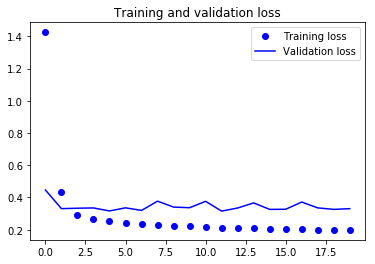

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 第一个循环网络基准----GRU

In [17]:
#前一个方法直接将时间序列展平，这从数据中删除了时间概念
#保留并利用时序（因果关系和顺序），尝试循环序列处理问题
#训练并评估一个基于GRU的模型
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 191s - loss: 0.3030 - val_loss: 0.2702
Epoch 2/20
500/500 [==============================] - 219s - loss: 0.2850 - val_loss: 0.2682
Epoch 3/20
500/500 [==============================] - 198s - loss: 0.2771 - val_loss: 0.2719
Epoch 4/20
500/500 [==============================] - 199s - loss: 0.2687 - val_loss: 0.2670
Epoch 5/20
 82/500 [===>..........................] - ETA: 114s - loss: 0.2653

KeyboardInterrupt: 

In [10]:
#训练并评估一个使用dropout正则化的基于GRU的模型
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                    recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])
                    ))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
499/500 [============================>.] - ETA: 0s - loss: 0.3407

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#训练并评估一个使用dropout正则化的堆叠GRU模型
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 413s - loss: 0.3361 - val_loss: 0.2777
Epoch 2/40
500/500 [==============================] - 401s - loss: 0.3120 - val_loss: 0.2700
Epoch 3/40
500/500 [==============================] - 396s - loss: 0.3080 - val_loss: 0.2690
Epoch 4/40
500/500 [==============================] - 397s - loss: 0.3007 - val_loss: 0.2695
Epoch 5/40
500/500 [==============================] - 397s - loss: 0.2980 - val_loss: 0.2648
Epoch 6/40
500/500 [==============================] - 400s - loss: 0.2949 - val_loss: 0.2617
Epoch 7/40
500/500 [==============================] - 401s - loss: 0.2912 - val_loss: 0.2660
Epoch 8/40
500/500 [==============================] - 397s - loss: 0.2876 - val_loss: 0.2670
Epoch 9/40
499/500 [============================>.] - ETA: 0s - loss: 0.2857

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
#逆序生成器
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

lookback = 1440
step = 6
delay = 144
batch_size = 128
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [9]:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size
#训练并评估一个基于GRU的模型(逆序)
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen_reverse,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 126s - loss: 0.4807 - val_loss: 0.4853
Epoch 2/20
500/500 [==============================] - 125s - loss: 0.4527 - val_loss: 0.4645
Epoch 3/20
500/500 [==============================] - 125s - loss: 0.4120 - val_loss: 0.4471
Epoch 4/20
500/500 [==============================] - 125s - loss: 0.3821 - val_loss: 0.4784
Epoch 5/20
500/500 [==============================] - 125s - loss: 0.3569 - val_loss: 0.4583
Epoch 6/20
500/500 [==============================] - 126s - loss: 0.3389 - val_loss: 0.4555
Epoch 7/20
500/500 [==============================] - 125s - loss: 0.3258 - val_loss: 0.4641
Epoch 8/20
500/500 [==============================] - 124s - loss: 0.3108 - val_loss: 0.4698
Epoch 9/20
500/500 [==============================] - 124s - loss: 0.2986 - val_loss: 0.4666
Epoch 10/20
500/500 [==============================] - 125s - loss: 0.2858 - val_loss: 0.4556
Epoch 11/20
500/500 [==============================] - 125s - loss: 0

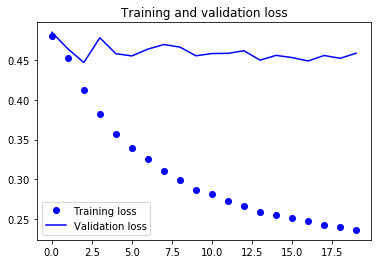

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
#使用逆序序列在IMDB上训练并评估一个LSTM
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train),(x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 111s - loss: 0.4872 - acc: 0.7691 - val_loss: 0.3497 - val_acc: 0.8646
Epoch 2/10
19968/20000 [============================>.] - ETA: 0s - loss: 0.3074 - acc: 0.8820

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
from keras import backend as K
K.clear_session()

In [ ]:
#在IMDB上训练并评估一个双向LSTM
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train),(x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 254s - loss: 0.5476 - acc: 0.7279 - val_loss: 0.3917 - val_acc: 0.8468
Epoch 2/10
16384/20000 [=======================>......] - ETA: 44s - loss: 0.3224 - acc: 0.8755

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
#在天气数据上训练并评估一个双向GRU
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps
                             )

Epoch 1/40
500/500 [==============================] - 260s - loss: 0.2970 - val_loss: 0.2725
Epoch 2/40
500/500 [==============================] - 250s - loss: 0.2754 - val_loss: 0.2790
Epoch 3/40
500/500 [==============================] - 254s - loss: 0.2667 - val_loss: 0.2710
Epoch 4/40
240/500 [=============>................] - ETA: 92s - loss: 0.2615

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()